In [77]:
!pip install gymnasium
!pip install torch
!pip install matplotlib
!pip install wandb
!pip install python-dotenv

In [79]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [80]:
'''
The main objective is to use PyTorch to train a Deep Q Learning (DQN) agent on the CartPole-v1 task from Gymnasium.
'''
# Importing the required libraries

import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import os
from dotenv import load_dotenv
import wandb
import numpy as np
from collections import namedtuple, deque

In [81]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display
plt.ion()

In [82]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [83]:
from collections import namedtuple, deque

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)  # Use deque for efficient memory management
        self.capacity = capacity # Add capacity attribute to the ReplayMemory class

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [84]:
# Setting up DQN

class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):

        assert input_dim is not None, "Input dimension cannot be None"
        assert action_dim is not None, "Action dimension cannot be None"

        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [85]:
class Env():
    def __init__(self, envName, env_mode="human"):
        self.envName = envName
        self.env = gym.make(envName, render_mode=env_mode)
        self.state, _ = self.env.reset()
        self.done = False
        self.info = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Retrieve action and observation dimensions
        self.actionSpace = self.env.action_space.n
        self.obsSpace = self.env.observation_space.shape[0]

    def reset(self):
        self.state, _ = self.env.reset()
        self.done = False
        self.info = None
        return self.state

    def step(self, action):
        # Capture all returned values from env.step
        step_result = self.env.step(action)
        # Assign values based on the length of the returned tuple
        if len(step_result) == 4:
            nextState, reward, done, info = step_result
        elif len(step_result) == 5:  # Handle case with 5 return values
            nextState, reward, done, info, _ = step_result
        else:
            raise ValueError("Unexpected number of values returned from env.step")

        self.state = nextState
        self.done = done
        self.info = info
        return self.state, reward, self.done, self.info

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()

    def get_state(self):
        return self.state

In [86]:
# Initializing Environment
cp_env = Env("CartPole-v1", "human")

# Print the action space, observation space, and the initial state
print("Action Space:", cp_env.actionSpace)
print("Observation Space:", cp_env.obsSpace)
print("Initial State:", cp_env.get_state())

Action Space: 2
Observation Space: 4
Initial State: [ 0.01841345 -0.00265361  0.00539731  0.02117459]


In [87]:
# Running episodes
for episode in range(10):
    state = cp_env.reset()
    for t in range(500):
        cp_env.render()
        action = cp_env.env.action_space.sample()
        nextState, reward, done, info = cp_env.step(action)
        print(t, nextState, reward, done, info, action)

        if done:
            break

# Close the environment when done
cp_env.close()

0 [-1.2709769e-02 -2.1139428e-01 -2.0239483e-04  2.4574725e-01] 1.0 False False 0
1 [-0.01693765 -0.01626944  0.00471255 -0.0469995 ] 1.0 False False 1
2 [-0.01726304  0.17878462  0.00377256 -0.33819187] 1.0 False False 1
3 [-0.01368735 -0.01639081 -0.00299128 -0.04432166] 1.0 False False 0
4 [-0.01401517 -0.21146974 -0.00387771  0.24741599] 1.0 False False 0
5 [-0.01824456 -0.01629262  0.00107061 -0.04648753] 1.0 False False 1
6 [-1.8570414e-02  1.7881396e-01  1.4085905e-04 -3.3883247e-01] 1.0 False False 1
7 [-0.01499414 -0.01630999 -0.00663579 -0.04610514] 1.0 False False 0
8 [-0.01532034  0.17890649 -0.00755789 -0.3408743 ] 1.0 False False 1
9 [-0.01174221  0.37413514 -0.01437538 -0.63593096] 1.0 False False 1
10 [-0.0042595   0.17921661 -0.027094   -0.34780955] 1.0 False False 0
11 [-0.00067517 -0.01550971 -0.03405019 -0.06379195] 1.0 False False 0
12 [-0.00098536  0.18008347 -0.03532603 -0.3670205 ] 1.0 False False 1
13 [ 0.0026163   0.37568915 -0.04266644 -0.6706296 ] 1.0 False 

In [88]:
import torch.optim as optim

class DQNAgent:
    def __init__(self, env, input_dim, action_dim, memory_size=5000, batch_size=128, gamma=0.99, lr=1e-3, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=500):
        self.env = env
        self.action_dim = action_dim
        self.memory = ReplayMemory(memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.q_network = DQN(input_dim, action_dim).to(env.device)
        self.target_network = DQN(input_dim, action_dim).to(env.device)
        self.update_target_network()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(self.env.device)
            with torch.no_grad():
                return self.q_network(state).argmax().item()

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.env.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.env.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.env.device)
        next_states = torch.FloatTensor(next_states).to(self.env.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.env.device)

        q_values = self.q_network(states).gather(1, actions)
        next_q_values = self.target_network(next_states).max(1, keepdim=True)[0]
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = F.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.q_network.parameters(), 1)
        self.optimizer.step()
        return loss.item()

    def update_experience(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * np.exp(-1.0 / self.epsilon_decay))



In [89]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Check if USE_WANDB is correctly loaded
use_wandb = os.environ.get("USE_WANDB", "false").lower() == "true"

# Debug print
print(f"Wandb usage is set to: {use_wandb}")

if use_wandb:
    import wandb
    print("Wandb imported successfully.")
else:
    print("Wandb not enabled. USE_WANDB is set to false.")


Wandb usage is set to: False
Wandb not enabled. USE_WANDB is set to false.


In [90]:
class WandbLogger:
    def __init__(self, config, project, env):
      if use_wandb:
        wandb.init(project = project, config = config)
        self.config = wandb.config
      else:
        self.config = config

    def log(self, args):
      if use_wandb:
        wandb.log(args)
      else:
        print(args)


In [105]:
def training(env, agent, num_episodes, batch_size, epsilon, gamma, learning_rate, epsilon_decay, C):
    max_steps = 500
    use_wandb = os.environ.get("USE_WANDB", "false").lower() == "true"

    losses = []
    rewards = []
    epsilons = []
    rewards_per_episode = {}

    if use_wandb:
        wandb_config = {
            'env': env.env_name,
            'algorithm': 'DQN',
            'batch_size': batch_size,
            'gamma': gamma,
            'eps_start': epsilon,
            'eps_decay': epsilon_decay,
            'target_update': C,
            'lr': learning_rate,
            'num_episodes': num_episodes,
            'max_timesteps': max_steps,
            'seed': 0
        }

        wandb = WandbLogger(wandb_config, f'assignment-2-part-2-{env.env_name}', env.env_name)

    steps = 0

    for episode in tqdm(range(num_episodes), desc="Training Progress"):
        state = env.reset()
        done = False
        episode_reward = 0
        total_loss = 0

        for t in range(max_steps):
            steps += 1
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            done = done or truncated
            agent.update_experience(state, action, reward, next_state, done)
            loss = agent.train_step()
            if loss:
                if use_wandb:
                    wandb.log({
                            'loss': loss,
                            'step_reward': reward,
                            'step': steps
                        })
                total_loss += loss
            episode_reward += reward
            state = next_state

            if done:
                break

        agent.update_target_network() if episode % C == 0 else None
        agent.decay_epsilon()
        losses.append(total_loss / (t + 1))
        rewards.append(episode_reward)
        epsilons.append(agent.epsilon)
        rewards_per_episode[episode] = episode_reward
        if use_wandb:
            wandb.log({
                    'epsilon': agent.epsilon,
                    'total_reward': episode_reward,
                    'epsilon': agent.epsilon,
                    'total_loss': total_loss,
                    'episode': episode
            })

    if use_wandb:
        wandb.finish()
    return rewards, losses, rewards_per_episode, epsilons

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
# Run Training
num_episodes = 1000
batch_size = 128
epsilon = 1.0
gamma = 0.99
learning_rate = 1e-3
epsilon_decay = 0.01
C = 10

cp_env = Env("CartPole-v1")
agent = DQNAgent(cp_env, cp_env.obsSpace, cp_env.actionSpace)

rewards, losses, rewards_per_episode, epsilons = training(cp_env, agent, num_episodes, batch_size, epsilon, gamma, learning_rate, epsilon_decay, C)

Training Progress: 100%|██████████| 1000/1000 [18:27<00:00,  1.11s/it]


In [93]:
def plot_rewards(rewards_per_ep, environment_type, epsilons=[]):
  episodes = np.array(list(rewards_per_ep.keys())).flatten()
  rewards = np.array(list(rewards_per_ep.values())).flatten()

  plt.figure(figsize=(10, 6))
  plt.plot(episodes, rewards, marker='o', linestyle='-', markersize=4)
  plt.title(f'Rewards per Episode {environment_type}')
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.grid(True)
  plt.xticks(range(0, max(episodes)+1, max(1, len(episodes)//10)))

  plt.tight_layout()
  plt.show()

In [94]:
def plot_epsilon_decay(epsilon_values, environment_type):
  plt.title(f'Epsilon Decay {environment_type}')
  plt.plot(epsilon_values)
  plt.xlabel('Episode', fontsize=18)
  plt.ylabel('Epsilon Values', fontsize=18)
  plt.title('Epsilon Decay', fontsize=26)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.grid()
  plt.show()

In [95]:
def plot_rewards_per_episode(rewards_per_episode, environment_type, epsilons=None, window_size=10):
    episodes = list(rewards_per_episode.keys())
    rewards = list(rewards_per_episode.values())
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, rewards, marker='o', linestyle='-', markersize=4, label='Rewards per Episode')
    if window_size > 1:
        moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        plt.plot(episodes[:len(moving_avg)], moving_avg, color='r', label=f'Moving Avg (window={window_size})')

    plt.title(f'Rewards per Episode {environment_type}', fontsize=20)
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Reward', fontsize=14)
    plt.grid(True)

    # Include epsilon plot if provided
    if epsilons:
        ax2 = plt.gca().twinx()
        ax2.plot(episodes, epsilons, color='g', alpha=0.6, linestyle='--', label='Epsilon')
        ax2.set_ylabel('Epsilon', fontsize=14)
        ax2.tick_params(axis='y', labelsize=12)

    plt.legend()
    plt.tight_layout()
    plt.show()
    return plt

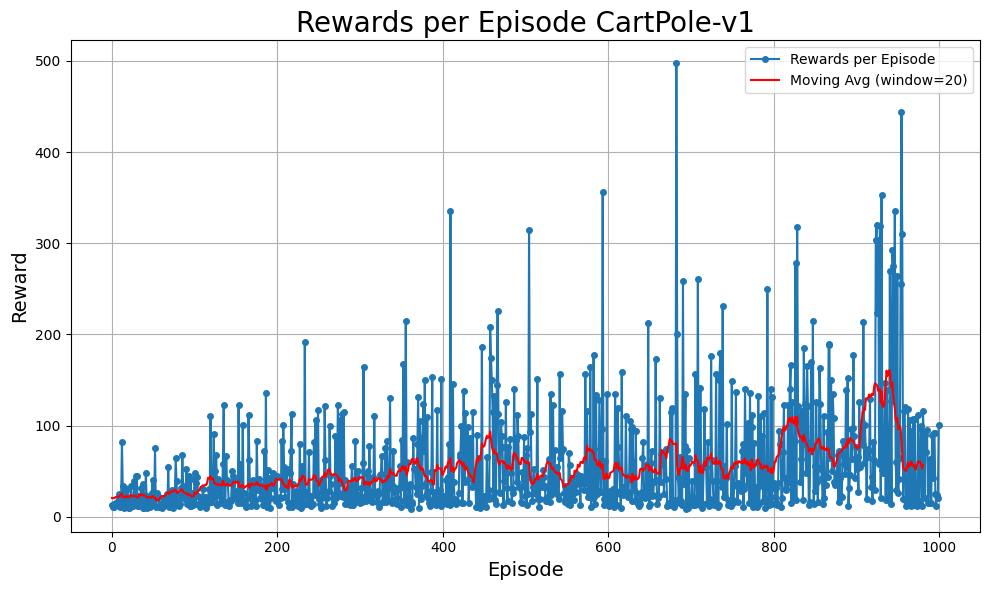

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [96]:
plot_rewards_per_episode(rewards_per_episode, 'CartPole-v1', window_size=20)

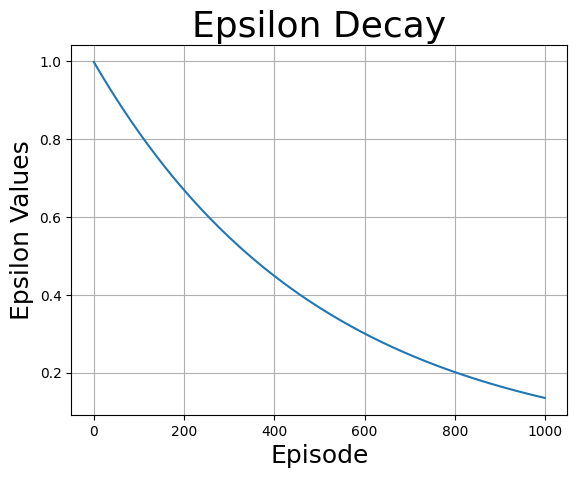

In [97]:
plot_epsilon_decay(epsilons, 'CartPole-v1')

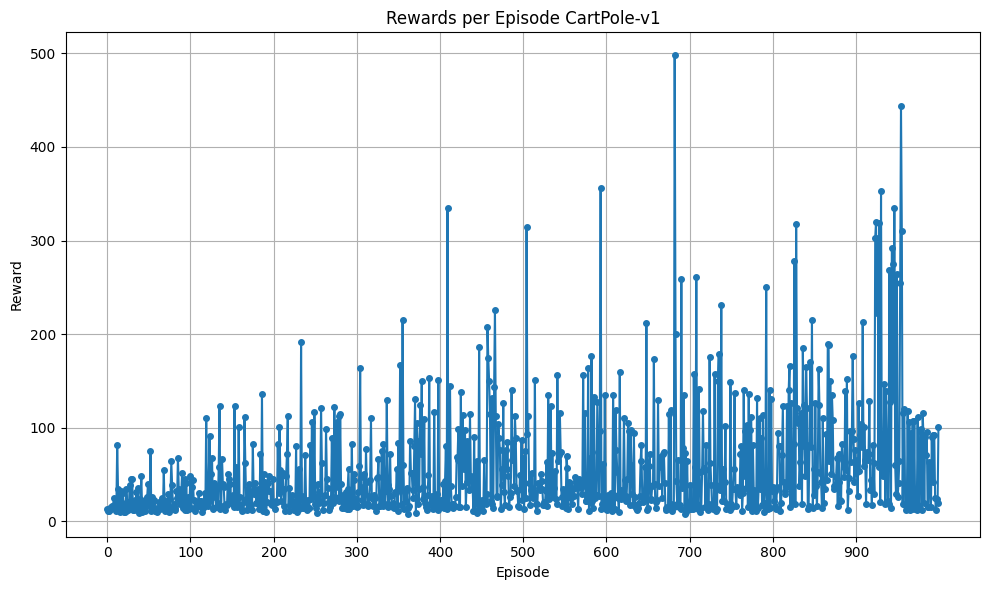

In [98]:
plot_rewards(rewards_per_episode, 'CartPole-v1')

In [99]:
torch.save(agent.q_network.state_dict(), "cartPole_v1_dqn.pth")

In [100]:
from functools import total_ordering
def greedy_policy(agent,model,env,num_episodes):
  epsilon = 0
  rewards = []
  rewards_per_episode = {}
  epsilons = []

  model.eval()
  total_rewards = 0

  for episode in tqdm(range(num_episodes), desc="Testing Progress"):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
      state_tensor = torch.FloatTensor(state).unsqueeze(0)
      with torch.no_grad():
        q_values = model(state_tensor)
        action = torch.argmax(q_values).item()

      next_state,reward,done,_ = env.step(action)
      episode_reward += reward
      state = next_state

      if done:
        break

    rewards.append(episode_reward)
    rewards_per_episode[episode] = episode_reward

  print(f"Rewards per episode: {rewards_per_episode}")
  rewards_per_episode_array = np.array(list(rewards_per_episode.values())).flatten()
  mean_rewards_per_episode = np.mean(rewards_per_episode_array)
  print(f"Mean rewards per episode: {mean_rewards_per_episode}")

  return mean_rewards_per_episode, rewards_per_episode, epsilons


In [101]:
model = DQN(cp_env.obsSpace, cp_env.actionSpace)
model.load_state_dict(torch.load("cartPole_v1_dqn.pth"))
mean_rewards_per_episode, rewards_per_episode, epsilons = greedy_policy(agent,model, cp_env ,num_episodes=100)

<ipython-input-101-edc98a879fcb>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cartPole_v1_dqn.pth"))
Testing Progress: 100%|██████████|

Rewards per episode: {0: 94.0, 1: 96.0, 2: 92.0, 3: 95.0, 4: 96.0, 5: 94.0, 6: 94.0, 7: 92.0, 8: 90.0, 9: 92.0, 10: 93.0, 11: 94.0, 12: 93.0, 13: 94.0, 14: 91.0, 15: 92.0, 16: 95.0, 17: 93.0, 18: 92.0, 19: 95.0, 20: 96.0, 21: 95.0, 22: 92.0, 23: 94.0, 24: 94.0, 25: 94.0, 26: 90.0, 27: 92.0, 28: 92.0, 29: 97.0, 30: 91.0, 31: 93.0, 32: 95.0, 33: 95.0, 34: 94.0, 35: 92.0, 36: 94.0, 37: 96.0, 38: 92.0, 39: 92.0, 40: 97.0, 41: 94.0, 42: 96.0, 43: 91.0, 44: 91.0, 45: 92.0, 46: 93.0, 47: 93.0, 48: 90.0, 49: 93.0, 50: 94.0, 51: 92.0, 52: 95.0, 53: 95.0, 54: 91.0, 55: 93.0, 56: 91.0, 57: 89.0, 58: 94.0, 59: 89.0, 60: 92.0, 61: 93.0, 62: 94.0, 63: 96.0, 64: 90.0, 65: 93.0, 66: 90.0, 67: 92.0, 68: 90.0, 69: 93.0, 70: 91.0, 71: 91.0, 72: 94.0, 73: 91.0, 74: 93.0, 75: 92.0, 76: 95.0, 77: 94.0, 78: 94.0, 79: 92.0, 80: 92.0, 81: 90.0, 82: 91.0, 83: 91.0, 84: 93.0, 85: 90.0, 86: 95.0, 87: 92.0, 88: 94.0, 89: 90.0, 90: 92.0, 91: 95.0, 92: 93.0, 93: 94.0, 94: 94.0, 95: 94.0, 96: 90.0, 97: 90.0, 98: 94.0

Avg Rewards per episode for Greedy Agent:  92.86


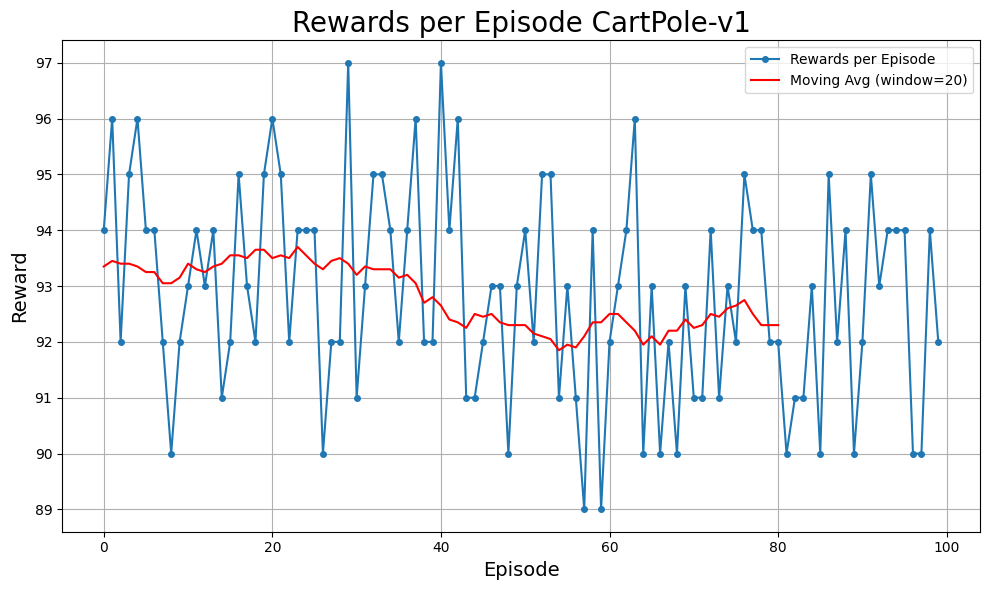

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [102]:
print("Avg Rewards per episode for Greedy Agent: ", mean_rewards_per_episode)
plot_rewards_per_episode(rewards_per_episode, 'CartPole-v1', window_size=20)

In [108]:
num_episodes = 1000
batch_size = 128
epsilon = 1.0
gamma = 0.99
learning_rate = 1e-3
epsilon_decay = 0.01
C = 10
state_dim = 36
action_dim = 6

wb_env = warehouseBotEnv()
agent = DQNAgent(wb_env, state_dim, action_dim)

wb_rewards, wb_losses, wb_rewards_per_episode, wb_epsilons = training(wb_env, agent, num_episodes, batch_size, epsilon, gamma, learning_rate, epsilon_decay, C)

Training Progress:   1%|          | 12/1000 [00:00<00:01, 745.85it/s]


ValueError: expected sequence of length 36 at dim 1 (got 2)

# **References:**

1.   https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
2.   https://medium.com/@vignesh.g1609/deep-q-learning-dqn-using-pytorch-a31f02a910ac
3.


